In [215]:
using Revise
using BilevelTrajOpt

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using ForwardDiff
using Plots

In [216]:
urdf = joinpath("..", "urdf", "panda", "panda_arm_plate.urdf")
mechanism = parse_urdf(Float64, urdf)
plate_body = findbody(mechanism, "panda_link8")
plate_frame = default_frame(plate_body)

mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));

# add frame vis to the plate
# setelement!(mvis, plate_frame);

In [ ]:
IJuliaCell(mvis)
# open(mvis)

In [202]:
settransform!(mvis["/Cameras/default/rotated"], MeshCat.Translation(-.25, -1.25, 0.075) 
    ∘ MeshCat.LinearMap(MeshCat.RotX(π/2))
    ∘ MeshCat.LinearMap(MeshCat.RotY(2*π/5)) 
)

MeshCat Visualizer with path /Cameras/default/rotated

In [ ]:
widget = manipulate!(mvis)

In [217]:
# traj opt without robustness

env = parse_contacts(mechanism, urdf, [])
x0 = MechanismState(mechanism)
Δt = 0.05
N = 20
traj_data = get_traj_data(mechanism,env,Δt,N,false,min_τ=false,min_v=true)

x_start = zeros(traj_data.num_q+traj_data.num_v)
x_goal = zeros(traj_data.num_q+traj_data.num_v)

x_start[1] = 0
x_start[2] = pi/4
x_start[3] = pi
x_start[4] = -3*pi/4
x_start[6] = -pi
x_goal[1] = -pi
x_goal[2] = -pi/4
x_goal[3] = pi
x_goal[4] = -pi/4
x_goal[6] = -pi

add_state_eq!(traj_data, xi -> xi - x_start, 1)
add_state_eq!(traj_data, xi -> xi - x_goal, N)
# note that the traj opt minimizes velocity too

traj = BilevelTrajOpt.trajopt_snopt(traj_data)

traj_t = vcat(0.,cumsum([Δt for i in 1:N-1]));
traj_q = [traj[1:num_positions(mechanism),i] for i in 1:N]
setanimation!(mvis, traj_t, traj_q)

Finished successfully: optimality conditions satisfied


In [226]:
setanimation!(mvis, traj_t, traj_q)

In [236]:
# robust version adds a "worst case scenario" computation for "wind gust" on the plate

world_frame = root_frame(mechanism)
function c_wind(q::AbstractArray{T}) where T
    state = MechanismState{T}(mechanism)
    set_configuration!(state, q)
    trans = relative_transform(state, plate_frame, world_frame)
    pn = (trans.mat * [0.,0.,1.,0.])[1:3]
    
    fw = w -> pn'*w
    hw = w -> [0.]
    gw = w -> vcat(w'*w - 4., w[3] - 1., -1. - w[3])
    w0 = zeros(3)
    λ0 = zeros(1)
    μ0 = zeros(3)
    
    wsol,λsol,μsol = auglag_solve(w0,λ0,μ0,fw,hw,gw,in_place=false,num_fosteps=1,num_sosteps=5,c0=0.01)

    10. * fw(wsol)^2
end

traj_data = get_traj_data(mechanism,env,Δt,N,false,min_τ=false,min_v=true)

x_start = zeros(traj_data.num_q+traj_data.num_v)
x_goal = zeros(traj_data.num_q+traj_data.num_v)

x_start[1] = 0
x_start[2] = pi/4
x_start[3] = pi
x_start[4] = -3*pi/4
x_start[6] = -pi
x_goal[1] = -pi
x_goal[2] = -pi/4
x_goal[3] = pi
x_goal[4] = -pi/4
x_goal[6] = -pi

add_state_eq!(traj_data, xi -> xi - x_start, 1)
add_state_eq!(traj_data, xi -> xi - x_goal, N)
# note that the traj opt minimizes velocity too

# noise as bilevel objective
# for i = 2:N-1
#     add_fn_obj!(traj_data, c_wind, i)
# end

# noise as bilevel constraint
for i = 9:11
    add_fn_ineq!(traj_data, qi -> c_wind(qi) - 25., i) 
end
# add_fn_ineq!(traj_data, qi -> c_wind(qi) - 25., 10) 

traj_robust = BilevelTrajOpt.trajopt_snopt(traj_data, opt_tol=1e-3,major_feas=1e-3,minor_feas=1e-3)

traj_robust_t = vcat(0.,cumsum([Δt for i in 1:N-1]));
traj_robust_q = [traj_robust[1:num_positions(mechanism),i] for i in 1:N]
setanimation!(mvis, traj_robust_t, traj_robust_q)

Finished successfully: optimality conditions satisfied


In [242]:
setanimation!(mvis, traj_robust_t, traj_robust_q)

In [237]:
# compute the disturbance along each trajectory (the one our solver used)

# with our solver
function compute_dist(q::AbstractArray{T}) where T
    state = MechanismState{T}(mechanism)
    set_configuration!(state, q)
    trans = relative_transform(state, plate_frame, world_frame)
    pn = (trans.mat * [0.,0.,1.,0.])[1:3]
    
    fw = w -> pn'*w
    hw = w -> [0.]
    gw = w -> vcat(w'*w - 4., w[3] - 1., -1. - w[3])
    w0 = zeros(3)
    λ0 = zeros(1)
    μ0 = zeros(3)
    
    wsol,λsol,μsol = auglag_solve(w0,λ0,μ0,fw,hw,gw,in_place=false,num_fosteps=1,num_sosteps=5,c0=0.01)
    10. * fw(wsol)^2
end

traj_dist = zeros(N)
traj_robust_dist = zeros(N)
for i = 1:N
    traj_dist[i] = compute_dist(traj_q[i])
    traj_robust_dist[i] = compute_dist(traj_robust_q[i])
end

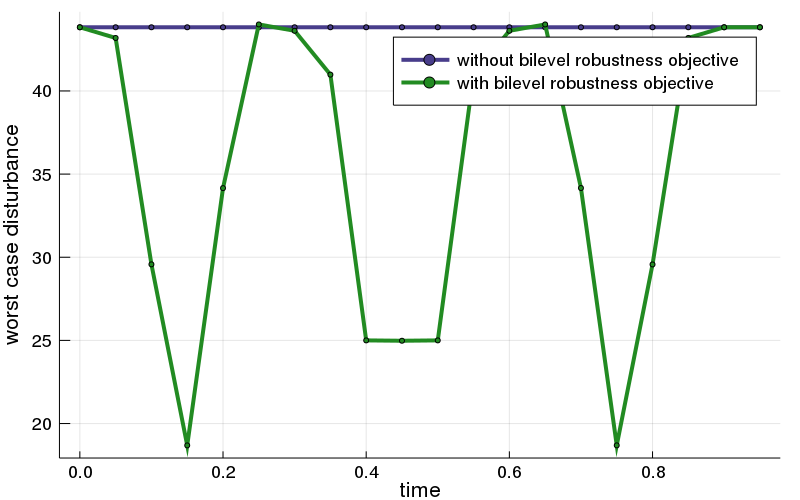

In [238]:
gr(size=(800,500), html_output_format=:png, seriescolor=:magma);
plot(traj_t,traj_dist,
    label="without bilevel robustness objective",
#     label="without bilevel robustness constraint",
    seriescolor=:darkslateblue,marker=3)
plot!(traj_robust_t,traj_robust_dist,
    label="with bilevel robustness objective",
#     label="with bilevel robustness constraint",
    seriescolor=:forestgreen,xlabel="time",ylabel="worst case disturbance",
    marker=3)

In [239]:
# with snopt directly (i.e. the "true" non-differentiable disturbance)

function compute_dist_snopt(q::AbstractArray{T}) where T
    state = MechanismState{T}(mechanism)
    set_configuration!(state, q)
    trans = relative_transform(state, plate_frame, world_frame)
    pn = (trans.mat * [0.,0.,1.,0.])[1:3]
    
    fw = w -> pn'*w
    gw = w -> vcat(w'*w - 4., w[3] - 1., -1. - w[3])
    function snopt_fn(w)
        J = fw(w)
        gJ = ForwardDiff.gradient(fw,w)
        
        c = gw(w)
        gc = ForwardDiff.jacobian(gw,w)
    
        fail = false
    
        J, c, gJ, gc, fail
    end
    
    w0 = zeros(3)
    lb = -1e19*ones(3)
    ub = 1e19*ones(3)
    options = Dict{String, Any}()
    options["Derivative option"] = 1
    options["Verify level"] = -1
    options["Major optimality tolerance"] = 1e-6
    wsol, fsol, info = snopt(snopt_fn, w0, lb, ub, options)

    10. * fw(wsol)^2
end

traj_dist_snopt = zeros(N)
traj_robust_dist_snopt = zeros(N)
for i = 1:N
    traj_dist_snopt[i] = compute_dist_snopt(traj_q[i])
    traj_robust_dist_snopt[i] = compute_dist_snopt(traj_robust_q[i])
end

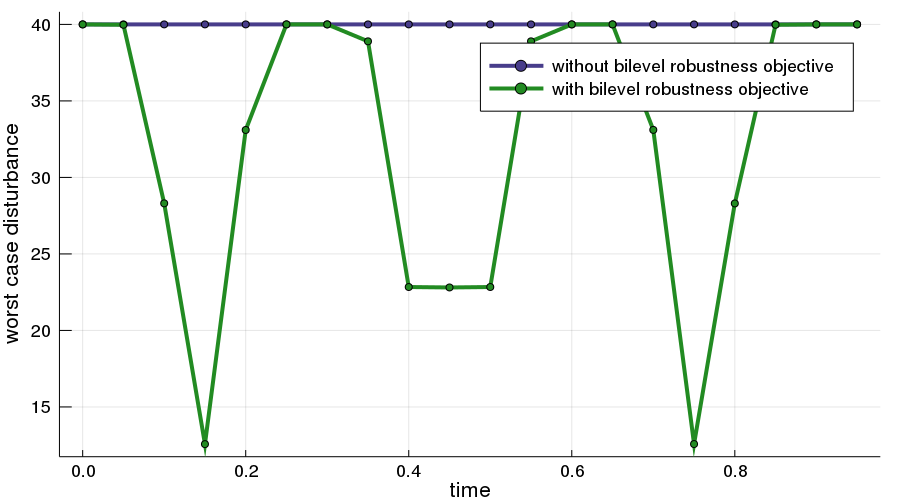

In [240]:
tickfont = font(12)
legendfont = font(12)
guidefont = font(14)
clibrary(:Plots)
gr(size=(900,500), html_output_format=:png, seriescolor=:magma, xtickfont=tickfont,
    ytickfont=tickfont,legendfont=legendfont,guidefont=guidefont,linewidth=4);

plot(traj_t,traj_dist_snopt,
    label="without bilevel robustness objective",
#     label="without bilevel robustness constraint",
    seriescolor=:darkslateblue,marker=4)
plot!(traj_robust_t,traj_robust_dist_snopt,
    label="with bilevel robustness objective",
#     label="with bilevel robustness constraint",
    seriescolor=:forestgreen,xlabel="time",ylabel="worst case disturbance",marker=4)

In [241]:
# savefig("figures/robust_snopt_objective.svg")
savefig("figures/robust_snopt_constraint.svg")

In [197]:
# playing with noise models

fw_ = (w,pn) -> pn'*w
hw = w -> [0.]
gw = w -> vcat(w'*w - 4., w[3] - 1., -1. - w[3])

function compute_dist(q::AbstractArray{T}) where T
    state = MechanismState{T}(mechanism)
    set_configuration!(state, q)
    trans = relative_transform(state, plate_frame, world_frame)
    pn = (trans.mat * [0.,0.,1.,0.])[1:3]
    
    fw = w -> fw_(w,pn)
    w0 = zeros(3)
    λ0 = zeros(1)
    μ0 = zeros(3)
    
    wsol,λsol,μsol = auglag_solve(w0,λ0,μ0,fw,hw,gw,in_place=false,num_fosteps=1,num_sosteps=5,c0=0.01)

    display(fw(wsol)^2)
    
    wsol
end

function compute_dist_snopt(q::AbstractArray{T}) where T
    state = MechanismState{T}(mechanism)
    set_configuration!(state, q)
    trans = relative_transform(state, plate_frame, world_frame)
    pn = (trans.mat * [0.,0.,1.,0.])[1:3]

    fw = w -> fw_(w,pn)
    function snopt_fn(w)
        J = fw(w)
        gJ = ForwardDiff.gradient(fw,w)
        
        c = gw(w)
        gc = ForwardDiff.jacobian(gw,w)
    
        fail = false
    
        J, c, gJ, gc, fail
    end
    
    w0 = zeros(3)
    lb = -1e19*ones(3)
    ub = 1e19*ones(3)
    options = Dict{String, Any}()
    options["Derivative option"] = 1
    options["Verify level"] = -1
    options["Major optimality tolerance"] = 1e-3
    wsol, fsol, info = snopt(snopt_fn, w0, lb, ub, options)

    display(fw(wsol)^2)
    
    wsol
end

q = configuration(mvis.state)
display(compute_dist(q))
display(compute_dist_snopt(q))

4.382818698911287

3-element Array{Float64,1}:
  0.31296995914052317
 -2.069728650601962  
 -0.03653663731322189

4.000000000000352

3-element Array{Float64,1}:
  0.29901175341410396 
 -1.9774204355186247  
 -0.020009810441564767

In [224]:
IJuliaCell(mvis)

WebIO.Scope("scope-223f2a1a-68df-402d-8718-cbc02a817bde", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :iframe), Any[], Dict{Symbol,Any}(:attributes=>Dict{String,Any}("height"=>"100%","scrolling"=>"no","src"=>"javascript:void(0)","frameborder"=>0),:id=>"ifr",:style=>Dict("width"=>"100%","flexGrow"=>"1")), 0)], Dict{Symbol,Any}(:style=>Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden")), 1), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}(), Set(String[]), nothing, Any[], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Ensure that the iframe's baseURI matches the baseURI of the\n    // outer document. This is necessary to resolve\n    // https://github.com/JuliaGizmos/WebIO.jl/issues/167\n    var base = doc.createElement(\"base\");\n    base.setAttribute(\"href\", document.baseURI);\n    doc.head.appendChild(base);\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;/assetserver/4e6dc072e028c3b44a2abd252ef43801b1ba6ad7-main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-d3f930dd-5cb0-47a7-b07b-689730422443&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-d3f930dd-5cb0-47a7-b07b-689730422443&quot;,&quot;id&quot;:&quot;ob_60&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); window.document.body.style.margin=&quot;0&quot;; return window.meshcat_viewer=this.viewer})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_59&quot;,&quot;value&quot;:[131,167,111,112,116,105,111,110,115,130,164,112,108,97,121,195,171,114,101,112,101,116,105,116,105,111,110,115,1,170,97,110,105,109,97,116,105,111,110,115,153,130,164,99,108,105,112,131,164,110,97,109,101,167,100,101,102,97,117,108,116,163,102,112,115,30,166,116,114,97,99,107,115,146,131,164,110,97,109,101,169,46,112,111,115,105,116,105,111,110,164,107,101,121,115,220,0,29,130,164,116,105,109,101,0,165,118,97,108,117,101,147,203,0,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,130,164,116,105,109,101,1,165,118,97,108,117,101,147,203,0,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,130,164,116,105,109,101,2,165,118,97,108,117,101,147,203,0,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,130,164,116,105,109,101,3,165,118,97,108,117,101,147,203,0,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,130,164,116,105,109,101,4,165,118,97,108,117,101,147,203,0,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,20

In [23]:
widget = manipulate!(mvis)

Widgets.Widget{:rbd_manipulator,Any}(OrderedCollections.OrderedDict{Symbol,Any}(:panda_link0_to_world=>Widget{:rbd_joint,Any}(OrderedCollections.OrderedDict{Symbol,Any}(), Observable{Any} with 1 listeners. Value:
nothing, nothing, defaultlayout),:panda_joint1=>Widget{:rbd_joint,Any}(OrderedCollections.OrderedDict{Symbol,Any}(:q1=>Widget{:slider,Float64}(OrderedCollections.OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
315,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["-3.14159", "-3.13159", "-3.12158", "-3.11158", "-3.10157", "-3.09157", "-3.08156", "-3.07156", "-3.06155", "-3.05155"  …  "3.05155", "3.06155", "3.07156", "3.08156", "3.09157", "3.10157", "3.11158", "3.12158", "3.13159", "3.14159"],:formatted_value=>Observable{String} with 1 listeners. Value:
"0.0",:value=>Observable{Float64} with 2 listeners. Value:
0.0), Observable{Float64} with 2 listeners. Value:
0.0, Scope("knockout-component-8e01381c-948e-45ab-8e63-8bf7efbaeb0d", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["panda_joint1.q1"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>629,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["-3.14159", "-3.13159", "-3.12158", "-3.11158", "-3.10157", "-3.09157", "-3.08156", "-3.07156", "-3.06155", "-3.05155"  …  "3.05155", "3.06155", "3.07156", "3.08156", "3.09157", "3.10157", "3.11158", "3.12158", "3.13159", "3.14159"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"0.0", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
315, nothing)), Set(String[]), nothing, Any["knockout"=>"/home/blandry/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/home/blandry/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/home/blandry/.julia/packages/InteractBase/3SqBl/src/../assets/style.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n            